In [1]:
papdir    =  '..'
outdir    =  '{0}/out'.format(papdir)
figdir    =  '{0}/figs'.format(papdir)
datdir     = '{0}/neutrophil_data'.format(papdir)
eigdir     = '{0}/eig'.format(outdir)

In [2]:
import numpy as np
import scipy as scipy
import sys
import os
import copy

sys.path.append('{0}/python'.format(papdir))
import myfun as mf
import pickle as pkl

import matplotlib
from matplotlib import gridspec, rc
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

rc('text',usetex=True)

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [3]:
pst_fname  = '{0}/pseudotime.txt'.format(datdir)
gnm_fname  = '{0}/gene_names.txt'.format(datdir)
meta_fname = '{0}/metadata.txt'.format(datdir)


print('loading cluster labels and SPRING positions')
dtp      = np.dtype([('Library Cell', np.unicode_, 16),('barcode', np.unicode_, 20),
              ('Time point', int),('Starting population', np.unicode_, 20),
               ('Cell type annotation', np.unicode_, 60),
               ('Well', int), ('SPRING-x', np.float64), ('SPRING-y', np.float64)])

metadata = np.genfromtxt(meta_fname, delimiter='\t',skip_header=1, dtype=dtp)

nms      = dtp.names
gnms     = np.genfromtxt(gnm_fname,dtype='str')


# In[9]:


keys           = metadata['Cell_type_annotation']
ctypes         = np.unique(keys)
ctype_idx_dict = dict(zip(ctypes,range(ctypes.shape[0])))
ctype_idxs     = np.array([ctype_idx_dict[k] for k in keys])
ctype_grps     = [np.where(ctype_idxs==i)[0] for i in range(len(ctypes))]
ctype_mean_pos = np.array([[np.mean(metadata['SPRINGx'][grp]),np.mean(metadata['SPRINGy'][grp])] 
                           for grp in ctype_grps])


# In[11]:

print('loading neutrophil pseudotime ranking')
neut_psts = np.genfromtxt(pst_fname, skip_header=True, dtype='int')


# In[12]:

print('binning gene expression')



print('eigen-decomposition')

pst_eig1     = np.load('{0}/dat_eval.npy'.format(eigdir))[:,0]
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]

# In[16]:

# this takes a while, so run with script: pca_gene_resample.py -- see README.md for details

#pst_grp_null_eval     = np.load('{0}/w1_gene_resample_bsz{1}_ns{2}.npy'.format(datdir, bin_sz, nsamp))
pst_grp_null_eval     = np.array([np.load('{0}/shuf_eval_t{1}.npy'.format(eigdir,i))[:,0] for i in range(pst_eig1.shape[0])])
pst_grp_null_eval_mu  = np.mean(pst_grp_null_eval,axis=1)
pst_grp_null_eval_err = np.std(pst_grp_null_eval,axis=1)

# In[17]:


pst_eig1_n              = pst_eig1 - np.amin(pst_eig1)
pst_grp_null_eval_n     = pst_grp_null_eval-np.amin(pst_grp_null_eval)
pst_grp_null_eval_mu_n  = np.mean(pst_grp_null_eval_n,axis=1)
pst_grp_null_eval_err_n = np.std(pst_grp_null_eval_n,axis=1)
npsts = len(pst_eig1)

loading cluster labels and SPRING positions
loading neutrophil pseudotime ranking
binning gene expression
eigen-decomposition


In [4]:
# In[18]:

###############################################################
# gene expression of highly varying, highly expressed genes...#
###############################################################
print('matrix of gene expression for highly expressed / varying genes')

nnz_thresh  = 0
cv_thresh   = 0.5
gexp_thresh = 1

#mu_gexp = np.array([np.mean(gexp_lil[cidxs].toarray(),axis=0) for cidxs in neut_pst_cidxs]) # takes like a minute
mu_gexp = np.load('{0}/high_var_gexp_trajs.npy'.format(datdir))
# save mu_gexp!

# In[19]:

nnzs         = np.sum(mu_gexp>0,axis=0)
mu_mu_gexp   = np.mean(mu_gexp,axis=0)
max_mu_gexp  = np.max(mu_gexp,axis=0)

std_mu_gexp = np.std(mu_gexp,axis=0)
cvs         = np.divide(std_mu_gexp, mu_mu_gexp, out = np.zeros(mu_gexp.shape[1]), where=mu_mu_gexp>0)

gidxs       = np.where((nnzs > nnz_thresh) & (cvs>cv_thresh) & (max_mu_gexp>gexp_thresh))[0]
am_sort     = mf.argmaxsort(mu_gexp[:,gidxs])
gexp_arr    = mu_gexp[:,gidxs[am_sort[0]]].T

matrix of gene expression for highly expressed / varying genes


In [5]:
gexp_norm = np.linalg.norm(mu_gexp,axis=1)

In [6]:
gexp_norm_outer = np.outer(gexp_norm, gexp_norm)
mu_gexp_cc = mu_gexp.dot(mu_gexp.T)/gexp_norm_outer

In [7]:
# dnb calculation
#dnb_biom = np.load('{0}/pst_dnb_nnz_0_cv0-5_gexp1.npy'.format(datdir))
dnb_biom = np.load('{0}/dnb/pst_dnb_markers.npy'.format(datdir))
dnb_biom_rand = np.load('{0}/dnb/pst_dnb_random.npy'.format(datdir))
dnb_rand_mu = np.mean(dnb_biom_rand, axis=0)
dnb_rand_std = np.std(dnb_biom_rand, axis=0)
dnb_rand_err = dnb_rand_std / np.sqrt(dnb_biom_rand.shape[0])

In [8]:
ctypes_fix = [x.replace('_','\_') for x in ctypes]

making figure 3
saved figure 3


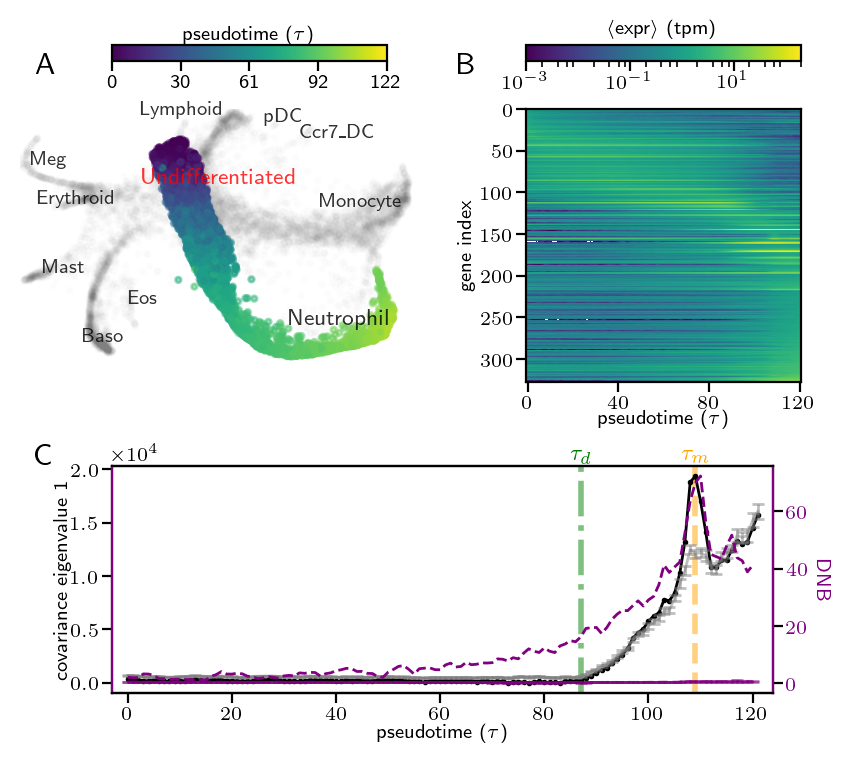

In [9]:
############################
#### fig 3 #################
############################
print('making figure 3')

plt.style.reload_library()
plt.style.use('{0}/sty/one_col_fig_7.mplstyle'.format(papdir))

t_bifurc = 109
t_bifurc_pf = 87

taulims = np.array([-3,124])
pst_label = r'pseudotime ($\tau$)'
leg_ht  = 2
leg_spc = 5
spc1_ht  = 7
spc2_ht = 2
spc1 = 1
schem1_ht   = 30
tseries_ht = 50
tau_series_ht = 25

col1_wd = 30
col2_wd = 30
spc_wd = 15
spc2_wd=1
spc3_wd=10

wds = np.array([
    spc3_wd,
    col1_wd,
    spc_wd,
    col2_wd-spc2_wd-leg_ht,
    spc2_wd,
    leg_ht
])

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

# row heights
hts = np.array([
    
    leg_ht,
    leg_spc,
    
    schem1_ht,   
    spc1_ht,
    spc2_ht,
    
    tau_series_ht,
])

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 12.8/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axAL = plt.subplot( gs[0    :rs[0],cs[0]:cs[1]]) # SPRING heat map legend
axA  = plt.subplot( gs[rs[1]:rs[3],0:cs[2]]) # SPRING heat map

axBL = plt.subplot( gs[0    :rs[0], cs[2]:]) # gene expression heat map legend
axB  = plt.subplot( gs[rs[1]:rs[2], cs[2]:]) # gene expression heat map

axC  = plt.subplot( gs[rs[4]:rs[5], cs[0]:cs[3]]) # covariance eigenvalue

caps = ['A','B','C']
ri   = [0,   0, rs[4]]
ci   = [0,cs[1],0]
ys   = [0,0,4]
xs   = [2,9,2]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], 
                x=xs[i],
                y=ys[i],fontsize=11,verticalalignment='top',horizontalalignment='left')
    cap_ax.axis('off')
    
#####################################
## A: SPRING plot                ####
#####################################
ab_cap_fs = 7
skip=10

# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.01)

axA.set_xlim(springXlims[0],springXlims[1]+1500)
axA.set_ylim(springYlims[0]-1500,springYlims[1])

# annotate cell types
ctype_offset = {'Monocyte':np.array([-500,200]),
               'Undifferentiated':np.array([-700,350]),
               'Lymphoid':np.array([-1300,100]),
                'pDC':np.array([-50,150]),
                'Erythroid':np.array([-400,0]),
               'Baso':np.array([-200,-400]),
               'Meg':np.array([-150,100])}

for i in range(len(ctypes)):
    axA.annotate(xy=ctype_mean_pos[i]+ctype_offset.get(ctypes[i],np.array([0,0])),
                 text=ctypes_fix[i],alpha=0.8,
                 fontsize=8 if ctypes[i] in ['Undifferentiated', 'Neutrophil'] else 7, 
                 color='red' if ctypes[i]=='Undifferentiated' else 'black')
    
# plot points in neutrophil trajectory
skip = 10
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
        c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)

axA.set_xticks([])
axA.set_yticks([])

#frameless
axA.axis('off')

#colorbar
cmap   = matplotlib.colormaps['viridis'] #plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axAL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
#axAL.xaxis.tick_top()
axAL.set_xticklabels(np.array(np.around(np.linspace(0,npsts,nticks)),dtype='int'), fontsize=ab_cap_fs)
axAL.set_title(pst_label, fontsize=ab_cap_fs)

#####################################
## B: gene expression trajectory ####
#####################################

cmap = copy.copy(matplotlib.colormaps['viridis'])
cmap.set_bad('white')

im = axB.imshow(gexp_arr, cmap=cmap,aspect='auto',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=2e2))

axB.set_xlabel(pst_label,labelpad=-1, fontsize=ab_cap_fs)
axB.set_ylabel('gene index', fontsize=ab_cap_fs, labelpad=2)
axB.set_xticks(np.arange(0,121,40))


cbar = fig.colorbar(im, cax=axBL, orientation='horizontal', aspect=1)
cbar.set_label(r'$\langle$expr$\rangle$ (tpm)',rotation=0, labelpad=4, fontsize=ab_cap_fs)
axBL.xaxis.set_label_position('top')
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=3) 
axBL.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=100)
axBL.xaxis.set_minor_locator(locmin)



#####################################
## C: covariance eigenvalue        ##
#####################################
xtix_all = np.array([0,20,40,60,80,100,120])
cols = ['k','gray']

axC.plot(pst_eig1_n,'o-', label = 'data',markersize=1, color=cols[0])
axC.errorbar(np.arange(pst_eig1.shape[0]),pst_grp_null_eval_mu, yerr=pst_grp_null_eval_err, 
             color=cols[1], capsize=2,alpha=0.5, label='null')

axC.set_ylabel('covariance eigenvalue 1')#, linespacing=1)

axC.set_xticks(xtix_all)
#axC.set_xticklabels([])
axC.set_xlim(*taulims)
axC.set_xlabel(r'pseudotime ($\tau$)')
axC.set_yticks([0,5000,10000,15000,20000])

axC.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ### inset ###
# axCin = axC.inset_axes([0.12, 0.25, 0.5, 0.6],transform=axC.transAxes)
# ti=70
# tf=121

# col = 'blue'
# axCin.errorbar(np.arange(ti,tf),pst_eig1_n[ti:tf]-pst_grp_null_eval_mu[ti:tf],
#                yerr=pst_grp_null_eval_err[ti:tf],
#                color=col, capsize=1)
# axCin.set_yscale('symlog')
# axCin.set_yticks([-100,0,100,10000])

# difftxts = [r'${\omega_1^{\rm data}}$-', r'${\omega_1^{\rm null}}$']

# halines = ['right','left']
# for i in range(len(difftxts)):
#     axCin.text(x=0.55,y=1.02,s=difftxts[i],color=cols[i],horizontalalignment = halines[i],
#                transform=axCin.transAxes, verticalalignment='bottom')

# axCin.set_xticks(xtix_all[np.where(xtix_all>ti)])
# axCin.set_xticklabels([])

#plt.setp(axCin.spines.values(), color=col)
#plt.setp([axCin.get_xticklines(), axCin.get_yticklines()], color=col)
#axCin.tick_params(color=col, labelcolor=col)


# dnb biomarker plot
axC2 = axC.twinx()
dnb_ax_col = 'purple'
axC2.plot(np.arange(len(dnb_biom)),dnb_biom,'--',color=dnb_ax_col)
#axC2.plot(m1s,dnb_indic,'--', color = dnb_ax_col)
axC2.set_ylabel('DNB',labelpad=8, rotation=270, color=dnb_ax_col)

axC2.tick_params(axis='y', labelcolor=dnb_ax_col)
axC2.spines['left'].set_color(dnb_ax_col)
axC2.spines['right'].set_color(dnb_ax_col)

axC2.errorbar(np.arange(len(dnb_rand_mu)),dnb_rand_mu, yerr=dnb_rand_err, 
             color=dnb_ax_col, capsize=2,alpha=0.5, label='null', linestyle='--')

#axC2.set_yscale('symlog', linthresh=10)


# bifurcation lines

bif_axs = [axC]#, axCin]
zord = [0,0,1,0,0]
cols = ['orange','green']
bifts = np.array([t_bifurc,t_bifurc_pf])
lss = ['--','-.']
bifnms = [r'$\tau_{m}$',r'$\tau_{d}$']
bifxs = (bifts - taulims[0])/(taulims[1]-taulims[0]) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    axC.text(s=bifnms[j],x=bifxs[j],y=1.01,transform=axC.transAxes,color=cols[j],
             horizontalalignment = 'center', verticalalignment='bottom',fontsize=8)
    for i in range(len(bif_axs)):
        bif_axs[i].axvline(bifts[j],color=cols[j], linestyle = lss[j], alpha=0.5,zorder=zord[i],lw=2)


#plt.show()
plt.savefig('{0}/fig3_neut_cov_dnb.pdf'.format(figdir), bbox_inches='tight')
print('saved figure 3')

# In[ ]:

In [10]:
nt,nsamp = pst_grp_null_eval.shape
pst_null_flat = pst_grp_null_eval.reshape(-1)
pst_null_times = np.vstack([np.arange(nt) for i in range(nsamp)]).T.reshape(-1)

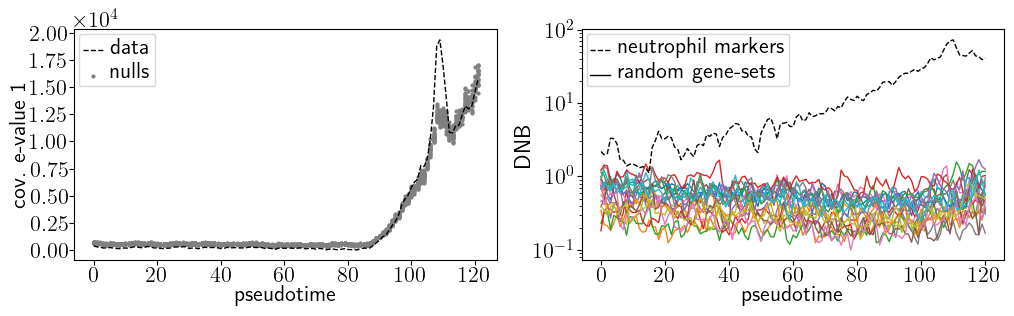

In [11]:
fig,axs=plt.subplots(1,2,figsize=(12,3))

cols = ['k','gray']

fs=16

axs[0].plot(pst_eig1_n,'--', label = 'data',markersize=1, color=cols[0])
axs[0].scatter(pst_null_times,pst_null_flat, color=cols[1], label='nulls')
#axs[0].set_yscale('log')
axs[0].set_ylabel('cov. e-value 1', linespacing=1)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].yaxis.get_offset_text().set_fontsize(fs)


axs[1].plot(dnb_biom_rand[0:20].T)
axs[1].plot(dnb_biom,'k--',label='neutrophil markers')
axs[1].plot(0,0,'k-',label='random gene-sets')

axs[1].set_yscale('log')
axs[1].set_ylabel('DNB')
axs[1].legend()

plt.subplots_adjust(wspace=0.2)

for ax in axs:
    ax.set_xlabel('pseudotime')
    mf.set_axs_fontsize(ax,fs,True)

plt.savefig('{0}/figS9_null_sup.pdf'.format(figdir), bbox_inches='tight')

In [12]:
# fig 4 start

In [13]:
with open('{0}/bin_cidxs.pkl'.format(eigdir), 'rb') as f:
    neut_pst_cidxs = pkl.load(f)

In [14]:
# In[24]:

###############################################################
# In[33]: schematic
###############################################################
print('loading schematic')
haem_dev_schem = plt.imread('{0}/pngs/neut_tree.png'.format(papdir))
schem_dy, schem_dx, _ = haem_dev_schem.shape



###############################################################
# type densities
###############################################################
print('cluster label in pseudotime')
types_per_group_neut = [ctype_idxs[np.array(grp,dtype='int')] for grp in neut_pst_cidxs] 
type_bins            = np.arange(-0.5,len(ctypes)+0.5,1)
type_denss_neut      = np.array([
    np.histogram(grp, bins=type_bins, density=True)[0] if len(grp)>0 else blank_hist 
    for grp in types_per_group_neut])


# In[25]:


###############################################################
# marker gene expression
###############################################################

# In[26]:

print('marker gene expression')
gene_group_labs  = ['neutrophil','MPP','GPP','PMy','My']

neut_gnms        = np.array(['S100a9', 'Itgb2l', 'Elane', 'Fcnb', 'Mpo', 'Prtn3', 
                              'S100a6', 'S100a8', 'Lcn2', 'Lrg1'])
mpp_gnms         = np.array(['Ly6a','Meis1','Flt3','Cd34'])
gmp_gnms         = np.array(['Csf1r','Cebpa'])
pmy_gnms         = np.array(['Gfi1','Elane'])
my_gnms          = np.array(['S100a8','Ngp','Ltf'])

grp_gnms  = [neut_gnms, mpp_gnms, gmp_gnms, pmy_gnms, my_gnms]

grp_gidxs = [np.array([np.where(gnms==gnm)[0][0] for gnm in k]) for k in grp_gnms]


# In[27]:


# grp_gexp = [[np.hstack([gexp_lil[cidxs, k].toarray() for k in grp]) 
#              for cidxs in neut_pst_cidxs]
#             for grp in grp_gidxs]
with open('{0}/marker_gene_trajs.pkl'.format(datdir), 'rb') as f:
    grp_gexp = pkl.load(f)
# save grp_gexp!

# In[28]:


grp_mu_gexp   = [np.array([np.mean(grp_gexp[i][t],axis=0) for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]
grp_std_gexp  = [np.array([np.std(grp_gexp[i][t],axis=0) for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]
grp_sem_gexp  = [np.array([grp_std_gexp[i][:,t]/np.sqrt(grp_gexp[i][t].shape[1]) 
                           for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]

loading schematic
cluster label in pseudotime
marker gene expression


making figure 4
saved fig 4


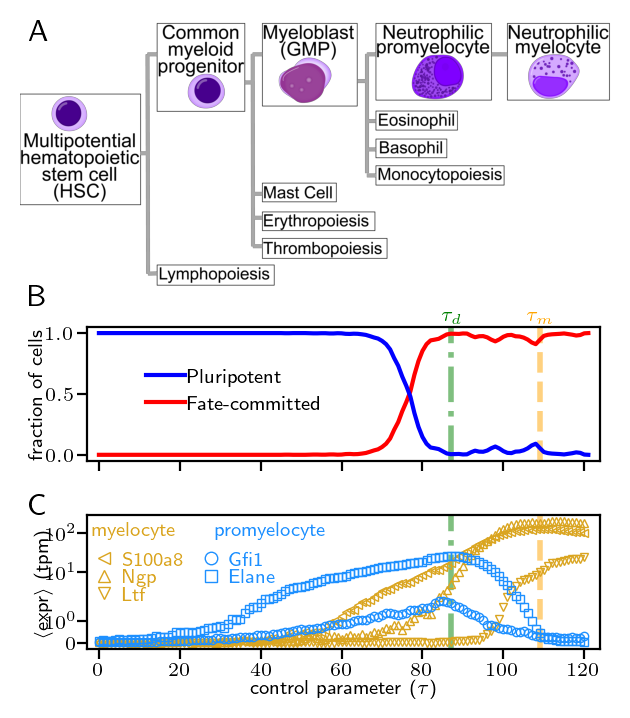

In [15]:
###############################################################
# In[127]: fig 4 ##############################################
###############################################################

print('making figure 4')

plt.style.reload_library()
plt.style.use('{0}/sty/one_col_fig.mplstyle'.format(papdir))

matplotlib.rcParams.update({'font.size': 7,
                            'axes.titlesize':7, 
                            'axes.labelsize':7,
                            'xtick.labelsize':7,
                           'ytick.labelsize':7,
                           'legend.fontsize':7})
taulims = [-3,124]

marg_ht = 1
#schem_ht = 6
tau_series_ht = 8
spc1_ht = 3
spc2_ht = 3

marg_wd = 1
tau_series_wd = 30

wds = np.array([
    marg_wd,
    tau_series_wd
])

wds = np.array(wds/np.min(wds),dtype='int')

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

schem_ht = int(schem_dy/schem_dx*nc)

# row heights
hts = np.array([
    
    marg_ht,
    schem_ht,   
    spc1_ht,
    tau_series_ht,
    spc2_ht,
    tau_series_ht
    
])

hts = np.array(hts/np.min(hts),dtype='int')

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 8.7/2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[0]:rs[1],cs[0]:]) # neut_dev_schem
axB  = plt.subplot( gs[rs[2]:rs[3], cs[0]:]) # clusters
axC  = plt.subplot( gs[rs[4]:rs[5], cs[0]:]) # genes


caps = ['A','B','C']
ri   = [0,rs[2],rs[4]]
ci   = [0,0,0]
ys   = [1,4,2.5]
xs   = [-1.5,-1.5,-1.5]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], 
                x=xs[i],
                y=ys[i],fontsize=11,verticalalignment='top',horizontalalignment='right')
    cap_ax.axis('off')
    
#####################################
## A: neutrophil dev schematic     ##
#####################################
taulims = [-3,124]

axA.set_xticks([])
axA.set_yticks([])
axA.set_ylim(0,schem_dy)
axA.set_xlim(0,schem_dx)
axA.imshow(haem_dev_schem,extent=[-0.13*schem_dx,1.02*schem_dx,
                                  -0.08*schem_dy,1.07*schem_dy],clip_on=False)
#axA.imshow(haem_dev_schem)
#axA.margins(0)

axA.axis('off')

#####################################
## B: cell type fraction           ##
#####################################

cols = ['red','blue','green']
col_idx = 0
lab_dict = {'Undifferentiated':'Pluripotent','Neutrophil':'Fate-committed'}
for i in np.arange(len(ctypes)):
    if max(type_denss_neut[:,i]>=0.1):
        axB.plot(type_denss_neut[:,i], label=lab_dict[ctypes[i]], lw=1.5, color = cols[col_idx])
        col_idx += 1

axB.set_ylabel('fraction of cells', linespacing=1)
handles, labels = axB.get_legend_handles_labels()
leg = axB.legend(handles[::-1], labels[::-1],frameon=False, loc=(0.1,0.3), handletextpad=0.1)
axB.set_xticklabels([])
axB.set_xlim(*taulims)
axB.set_yticks([0,0.5,1])

#####################################
## C: myeloid gene expression      ##
#####################################

# other version which includes promyelocite genes
grps = [4,3]
cols = ['goldenrod','dodgerblue']
marks = [['<','^','v'],['o','s']]
msz = [3,3,3]
fs = ['none','none','none']

for i in range(len(grps)):
    mu_gexp = grp_mu_gexp[grps[i]]
    ggnms = grp_gnms[grps[i]]
    for g in range(mu_gexp.shape[0]):
        axC.plot(np.arange(mu_gexp.shape[1]),mu_gexp[g], marker = marks[i][g],markersize=msz[i],
             color=cols[i], label=ggnms[g], fillstyle=fs[i], markeredgewidth=0.5,linestyle='none') 
    
axC.set_yscale('symlog')
#axC.set_yscale('log')
axC.tick_params(axis='y', which='major', pad=0)
leg = axC.legend(labelspacing=0,frameon=False, loc=(0,0.28),ncol=2,columnspacing=0.9, handlelength=1,
                handletextpad=0.4,markerscale=1.5)
axC.set_ylabel(r'$\langle$expr$\rangle$ (tpm)',labelpad=-2.5)

for i,text in zip(range(5),leg.get_texts()):
    plt.setp(text, color = cols[0] if i<len(marks[0]) else cols[1])

# both versions, x-axis
axC.set_xlim(*taulims)
axC.set_xlabel(r'control parameter ($\tau$)')
axC.text(s='myelocyte',x=0.01,y=0.85,color=cols[0],fontsize=7,fontweight='bold',transform=axC.transAxes)
axC.text(s='promyelocyte',x=0.25,y=0.85,color=cols[1],fontsize=7,fontweight='bold',transform=axC.transAxes)


bif_axs = [axB,axC]
zord = [0,0,1,0,0]
cols = ['orange','green']
bifts = np.array([t_bifurc,t_bifurc_pf])
lss = ['--','-.']
bifnms = [r'$\tau_{m}$',r'$\tau_{d}$']
bifxs = (bifts - taulims[0])/(taulims[1]-taulims[0]) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    axB.text(s=bifnms[j],x=bifxs[j],y=1.02,transform=axB.transAxes,color=cols[j],
             horizontalalignment = 'center', verticalalignment='bottom')
    for i in range(len(bif_axs)):
        bif_axs[i].axvline(bifts[j],color=cols[j], linestyle = lss[j], alpha=0.5,zorder=zord[i],lw=2)

plt.savefig('{0}/fig4_neut_gexp.pdf'.format(figdir), bbox_inches='tight')

print('saved fig 4')